In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from netCDF4 import Dataset
import glob
import sys
import math
import matplotlib.pyplot as plt

import pyproj
pyproj.datadir.set_data_dir("../Data/")
from fiona.crs import from_epsg
import shapely
import warnings

# Exploring the IUCN Rangemap dataset

In [1]:
amp = gpd.read_file('../Data/AMPHIBIANS/AMPHIBIANS.shp')

NameError: name 'gpd' is not defined

In [181]:
amp_coords = gpd.read_file('../Data/IUCN_AMPHIBIA_coords_run01.csv')

This works

In [159]:
amp.head()

,id_no,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,subspecies,subpop,...,order_,family,genus,category,marine,terrestial,freshwater,SHAPE_Leng,SHAPE_Area,geometry
0,57264,Engystomops montubio,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,None,None,...,ANURA,LEPTODACTYLIDAE,Engystomops,LC,false,true,true,5.755238,1.264393,"POLYGON ((-80.59473 -1.00518, -80.57579 -0.948..."
1,56133,Hyperolius ferreirai,1,1,1,IUCN,2014,IUCN (International Union for Conservation of ...,None,None,...,ANURA,HYPEROLIIDAE,Hyperolius,DD,false,true,true,0.420328,0.008667,"POLYGON ((14.72465 -9.07726, 14.71390 -9.08009..."
2,45536685,Telmatobius mendelsoni,4,1,1,Kelsey Neam,2017,IUCN (International Union for Conservation of ...,None,None,...,ANURA,TELMATOBIIDAE,Telmatobius,CR,false,false,true,0.497784,0.010478,"MULTIPOLYGON (((-71.58104 -13.20094, -71.58300..."
3,59422,Thorius omiltemi,1,1,1,Lauren Warr,2019,IUCN (International Union for Conservation of ...,None,None,...,CAUDATA,PLETHODONTIDAE,Thorius,EN,false,true,false,0.842579,0.010135,"POLYGON ((-99.83744 17.62612, -99.83715 17.626..."
4,55890,Pseudacris cadaverina,1,1,1,Lauren Warr,2020,IUCN (International Union for Conservation of ...,None,None,...,ANURA,HYLIDAE,Pseudacris,LC,false,true,true,38.489448,7.313197,"MULTIPOLYGON (((-114.70693 29.88815, -114.7126..."


In [160]:
amp.describe()

,id_no,presence,origin,seasonal,yrcompiled,generalisd,SHAPE_Leng,SHAPE_Area
count,9.330000e+03,9330.000000,9330.000000,9330.0,9330.000000,9330.000000,9330.000000,9.330000e+03
mean,2.124947e+07,1.331297,1.034727,1.0,2016.453269,0.001179,22.166819,1.763001e+01
std,4.600145e+07,1.069007,0.285939,0.0,4.228546,0.034318,69.215647,7.861223e+01
min,5.200000e+02,1.000000,1.000000,1.0,2004.000000,0.000000,0.001533,9.582333e-09
25%,5.596625e+04,1.000000,1.000000,1.0,2015.000000,0.000000,0.524554,1.051120e-02
50%,5.811900e+04,1.000000,1.000000,1.0,2018.000000,0.000000,3.291613,1.859049e-01
75%,1.360888e+05,1.000000,1.000000,1.0,2020.000000,0.000000,16.185944,2.961248e+00
max,2.225299e+08,6.000000,6.000000,1.0,2022.000000,1.000000,1793.326221,2.046439e+03


In [167]:
# Knoblauchkröte = Pelobates fuscus
'Pelobates fuscus' in amp['sci_name'].values
# > True

# Split out data series
kk = amp.loc[amp['sci_name'] == 'Pelobates fuscus']

print('dtype', type(kk))
print()
print('consistency check')
print('Calculated area', kk['geometry'].area)
print('documented area', kk['SHAPE_Area'])

dtype <class 'geopandas.geodataframe.GeoDataFrame'>

consistency check
Calculated area 3613    312.353336
dtype: float64
documented area 3613    312.353336
Name: SHAPE_Area, dtype: float64


The warning about the projection will become important later!

Let's focus on the Pelobates fuscus, because it has a funny name\
<img src="images/PelobatesFuscus.jpg" alt='Knoblauchkröte'/>

# Grid area with climate data longitude/latitude entries

In [168]:
# Load berkely dataset
clim_data = Dataset('../Data/Berkely_monthly_land/Complete_TAVG_LatLong1.nc')

In [169]:
# get central grid points within bounds (proof of concept - not fast)
from numpy import sin, pi
from time import time

t1 = time()
minx, miny, maxx, maxy = kk['geometry'].bounds.values[0]

lon = np.array(clim_data['longitude'])
lat = np.array(clim_data['latitude'])
lon_bounded = lon[(lon >= minx) & (lon <= maxx)]
lat_bounded = lat[(lat >= miny) & (lat <= maxy)]


x, y = np.meshgrid(lon_bounded, lat_bounded)
X = x.flatten(); Y = y.flatten()
df = pd.DataFrame({'longitude': X, 'latitude': Y})
df_geometry = gpd.points_from_xy(df.longitude, df.latitude)
lon_lat_bound = gpd.GeoDataFrame(df, geometry=df_geometry, crs= '{}'.format(kk.crs))

t2 = time()
# find points within region
kk_grid_bool = lon_lat_bound.within(kk.geometry.unary_union)
grid_shape = lon_lat_bound[kk_grid_bool].drop(['geometry'],axis=1)

t3 = time()
print('timing:')
print('get bounded grid:    {} s'.format(t2-t1))
print('get pts within area: {} s'.format(t3-t2))

timing:
get bounded grid:    0.01199030876159668 s
get pts within area: 4.9690635204315186 s


On my local machine, this will take 7 - 8 h for all 9330 amphibians --> try on cluster!

In [170]:
# consistency check: Area
## reprojekt to flat europe map
lon_lat_bound_reproj = lon_lat_bound.to_crs('EPSG:3034')
kk_geo_reproj = kk['geometry'].to_crs('EPSG:3034')

## calculate area by hand
R = 6371 # Earth radius [km]
lat_res = 1  / 360 * 2* pi; lon_res = 1  / 360 * 2* pi
lat = lon_lat_bound.latitude / 360 * 2* pi; lon = lon_lat_bound.longitude / 360 * 2* pi
lon_lat_bound['cell_area'] = R**2 * (sin((lat + lat_res/2)) - sin((lat - lat_res/2))) * lon_res
A_grid = lon_lat_bound[kk_grid_bool]['cell_area'].sum()
A_true = kk_geo_reproj.area.values[0] / 1e6 # m2 --> km2
print('Area of sum of grid cells: {} km²'.format(int(A_grid)))
print('Area of true shape:        {} km²'.format(int(A_true)))

Area of sum of grid cells: 2384943 km²
Area of true shape:        2234973 km²


In [216]:
# reload points from df - write func to reload and calc climate niches.
# a = amp_coords.loc[amp_coords['sci_name'] == 'Pelobates fuscus']
a = amp_coords.iloc[[-1]]
# points = shapely.points_from_xy(a['lon_lat_range'])
string = a['lon_lat_range'].values[0]
cleaned_string = string.replace('[', '').replace(']', '').replace('\n', '').split()
result_array = np.fromstring(' '.join(cleaned_string), sep=' ')
result_array = result_array.reshape((len(cleaned_string) // 2, 2))
points = gpd.points_from_xy(result_array[:,0], result_array[:,1])
points_df = gpd.GeoDataFrame(geometry = points, crs= '{}'.format(kk.crs))
points_df.explore()

In [217]:
a

,field_1,id_no,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,subspecies,...,family,genus,category,marine,terrestial,freshwater,SHAPE_Leng,SHAPE_Area,lon_lat_range,geometry
9329,9329,57434,Boophis vittatus,1,1,1,IUCN,2015,International Union for Conservation of Nature...,,...,MANTELLIDAE,Boophis,VU,false,true,true,6.60738219071,0.980249196264,[[ 49.5 -14.5]],None


In [171]:
# plot gridpoints
map = kk.explore()
lon_lat_bound[kk_grid_bool].explore(m=map,color='green', marker_kwds=dict(radius=5, fill=True))
lon_lat_bound[~kk_grid_bool].explore(m=map,color='red', marker_kwds=dict(radius=5, fill=True))

The Area calculation of the IUCN dataset, stored in the "SHAPE_Area" variable seems to be false due to the polygon shape being in WGS 84 (global degres). However, when reprojecting into a european projection, one finds the correct area and can use it to verify the gridded area given by 
$$ A = \sum_i\int_{\phi_i-\Delta/2}^{\phi_i+\Delta/2}d\phi\int_{\theta_i-\Delta/2}^{\theta_i+\Delta/2}d\theta r^2\sin\theta_i $$
for all grid points $(\phi_i, \theta_i)$ within geometry, r is earth's radius.

When taking gernamy's area of $\approx 300.000\: km^2$ as a reference, it seems plausible that the calculated area of $\approx 2.000.000\: km^2$ is around six times as large.

# Get max of the monthly mean temperature of historical records
The berkeley dataset consists of a **monthly** record of worldwide temperatures in a resolution of 1° x 1°. There are seperate datafiles for "TAVG, TMAX, and TMIN indicating fields for average temperature, maximum temperature, and minimum temperature, respectively" (see README).

Following the methodology of [Pigot et al. (2023), Nature](https://www.nature.com/articles/s41559-023-02070-4), the historical maximum of the monthly mean temperature can be obtained by taking the maximum of the monthly "TAVG" temperature values.

In [2]:
# import temperature data
x = Dataset('../Data/Berkely_monthly_land/Complete_TAVG_LatLong1.nc')

# get imortant variables
warnings.simplefilter("ignore")
lon=x.variables['longitude'][:]
lat=x.variables['latitude'][:]
temp=x.variables['temperature'][:]
time=x.variables['time'][:]


# create useful data array
import xarray as xr
TAVG_anomaly_data = xr.DataArray(temp.data, dims=('time', 'latitude', 'longitude'), coords=[time, lat, lon])

In [3]:
# time into datetime
from datetime import date, timedelta

def decimal_year_to_date(decimal_year):
    # INPUT:    decimal_year must be a single number (no array)
    # OUTPUT:   array of dates

    year = int(decimal_year)
    days_in_year = (decimal_year - year) * 365.25
    time_as_date = date(year, 1, 1) + timedelta(days_in_year)

    return time_as_date

# show that it works
print("The decimal year 1981.125 is converted to", decimal_year_to_date(1981.125))

# apply to array
time_dates = [decimal_year_to_date(t) for t in time.data]
TAVG_anomaly_data['time'] = pd.DatetimeIndex(time_dates).floor('D')

The decimal year 1981.125 is converted to 1981-02-15


In [4]:
# temperature is given in anomaly from climatology. Fix for it to get absolute temperatures
# Let max review this one!

climatology=x.variables['climatology'][:]
months = TAVG_anomaly_data['time.month']
TAVG_data = TAVG_anomaly_data + climatology[months - 1]

Konsistency check: Compare to mean temperatures of august in germany
<img src="images/Temperatur_Deutschland_August.png" width="500" height="300"/>

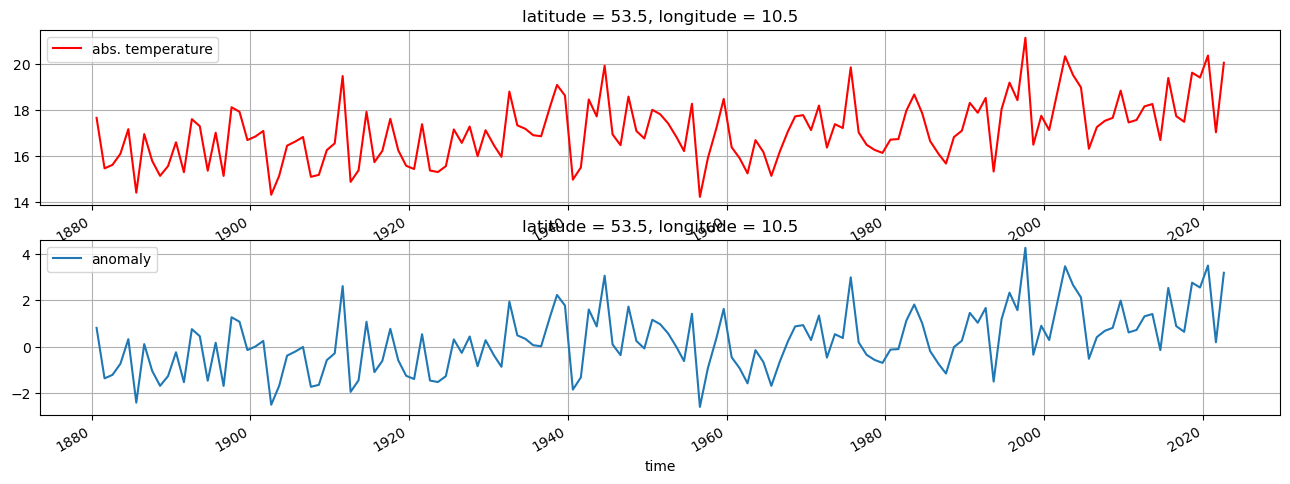

In [9]:
# plot august temperature and anomaly in some place in germany after 1880
T_aug = TAVG_data.sel(longitude=10.5, latitude=53.5).where((TAVG_data['time.month'] == 8) & (TAVG_data['time.year'] >= 1880))
T_aug_interpol = T_aug.interpolate_na(dim='time', method='linear')
T_anomaly_aug = TAVG_anomaly_data.sel(longitude=10.5, latitude=53.5).where((TAVG_anomaly_data['time.month'] == 8) & (TAVG_data['time.year'] >= 1880))
T_anomaly_aug_interpol = T_anomaly_aug.interpolate_na(dim='time', method='linear')

fig = plt.figure(figsize=(16,5))

plt.subplot(2,1,1)
T_aug_interpol.plot(color='r', label='abs. temperature')
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
T_anomaly_aug_interpol.plot(color='tab:blue',label='anomaly')
plt.grid(True)
plt.legend()


In [81]:
# max monthly tmeperature mmt
max_TAVG = TAVG_data.max('time')

# to dataframe
lon_mesh, lat_mesh = np.meshgrid(max_TAVG.longitude.data, max_TAVG.latitude.data)
mmt = pd.DataFrame({'longitude': lon_mesh.flatten(), 'latitude': lat_mesh.flatten(), 'max_TAVG': max_TAVG.data.flatten()})

# add cell area in km²
R = 6371 # Earth radius [km]
lat_res = 1  / 360 * 2 * np.pi; lon_res = 1  / 360 * 2 * np.pi
lat_rad = lat_mesh.flatten() / 360 * 2* np.pi; lon_rad = lon_mesh.flatten() / 360 * 2* np.pi
mmt['cell_area'] = R**2 * abs(np.sin((lat_rad + lat_res/2)) - np.sin((lat_rad - lat_res/2))) * lon_res

In [83]:
# get temperatures for grid cells within area
grid_shape = lon_lat_bound[kk_grid_bool].drop(['cell_area','geometry'],axis=1)
merged_df = pd.merge(grid_shape, mmt, left_on=['longitude', 'latitude'], right_on=['longitude', 'latitude'])
print('length:', len(merged_df))
merged_df.head()



length: 314


,longitude,latitude,max_TAVG,cell_area
0,25.5,43.5,26.434942,8968.694665
1,11.5,44.5,27.242315,8818.710421
2,22.5,44.5,24.696869,8818.710421
3,23.5,44.5,25.434952,8818.710421
4,24.5,44.5,25.968430,8818.710421


Maximum realized temperature: 27.2 °C


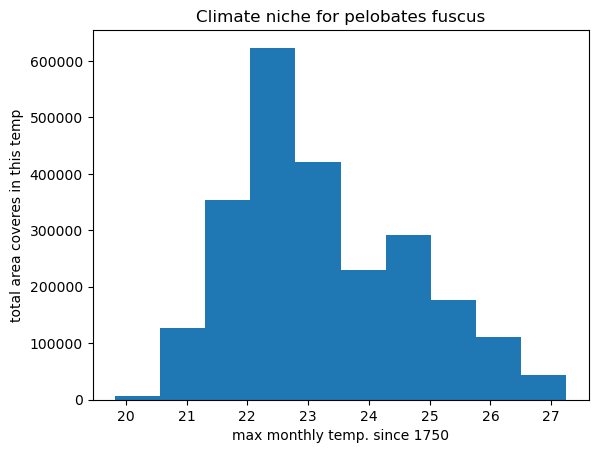

In [18]:
# calculate climate niche
hist = plt.hist(merged_df.max_TAVG.values, weights=merged_df.cell_area.values)
plt.title('Climate niche for pelobates fuscus')
plt.xlabel('max monthly temp. since 1750')
plt.ylabel('total area imhabited at this this temp')

print('Maximum realized temperature: {} °C'.format(np.round(merged_df['max_TAVG'].max(),1)))

However, since we don't have the abundance distribution, this histogram if quite meaningless. It is more interesting to look straight at the maximum realized climate niche.

All steps to calculate the maximum realized temperatrue for a species are now in the function "estimate_climate_niches.py" which is tested below.

In [23]:
# TEST FUNCTION
from estimate_climate_niches import max_realized_temp

kk_max_temp = max_realized_temp(kk, max_TAVG)
if np.isclose(kk_max_temp, 27.2423152923584):
  print("The maximum realized temperature for our favourite leapfrog is calculated correctly!")
else:
  print('\033[93m' + 'Something went wrong!')

The maximum realized temperature for our favourite leapfrog is calculated correctly!


# Max's code
Next step: Check code, adjust time and climate statistic and get range coords for all amphibia

In [24]:
# get 3 dates and test datetime code

# MAX: load daily climate data
def bring(file_name,var_name,yr0):
        x=Dataset(file_name)
        try:
                lon=x.variables['lon'][:]
        except:
                lon=x.variables['longitude'][:]
        try:
                lat=x.variables['lat'][:]
        except:
                lat=x.variables['latitude'][:]
        var=x.variables[var_name][:]

        #convert to -180>180 lon grid
        lon-=180
        var2=np.zeros(var.shape)
        var2[...,:int(var.shape[-1]/2)]=var[...,int(var.shape[-1]/2):]
        var2[...,int(var.shape[-1]/2):]=var[...,:int(var.shape[-1]/2)]

        #convert time to helpful datetime index
        dates=np.array(str(yr0) + '-01-01',dtype=np.datetime64)
        dts=np.linspace(0,len(x.variables['time'][:])-1,len(x.variables['time'][:]))
        dates=dates+dts.astype(int)
        dates=pd.DatetimeIndex(dates)

        return(lon,lat,var2,dates)


# From README: "For example, 1981.125 indicates February 1981"
t = ds.variables['time'][0:3]
print(t, 'This is 1750; Jan,Feb, Mrz')
yr0 = '1750'

dates=np.array(str(yr0) + '-01-01',dtype=np.datetime64)
dts=np.linspace(0,len(t)-1,len(t))
dates=dates+dts.astype(int)
dates=pd.DatetimeIndex(dates)
print('From func: Year-Month-Day: ', dates)

NameError: name 'ds' is not defined

In [ ]:
#calc monthly statistic of daily climate variable
def calc_month_stat(var,dates,stat):
        years=pd.unique(dates.year)
        var2=np.zeros((var.shape[1],var.shape[2],len(years),12))

        for i in range(len(years)):
                for j in range(12):
                        if stat=='std':
                                var2[:,:,i,j]=np.std(np.squeeze(var[np.where((dates.year==years[i]) & (dates.month==j+1)),:,:]),axis=0)
                        elif stat=='VAR':
                                var2[:,:,i,j]=np.square(np.std(np.squeeze(var[np.where((dates.year==years[i]) & (dates.month==j+1)),:,:]),axis=0))
                        elif stat=='mean':
                                var2[:,:,i,j]=np.mean(np.squeeze(var[np.where((dates.year==years[i]) & (dates.month==j+1)),:,:]),axis=0)
                        elif stat=='sum':
                                var2[:,:,i,j]=np.sum(np.squeeze(var[np.where((dates.year==years[i]) & (dates.month==j+1)),:,:]),axis=0)
                        else:
                                sys.exit('Specified incorrect statistic to calculate: use "std" or "mean" or "var"')
        return(var2)

Class=sys.argv[1]

In [ ]:
#which quarter of data to process
q_i=int(sys.argv[2])

if Class=='BIRDS':
	range_maps=gpd.read_file('/p/projects/impactee/Data/biodiverse/IUCN/BIRDS/a0000000a.gdbtable')
else:
	rfiles=glob.glob('/p/projects/impactee/Data/biodiverse/IUCN/' + Class + '/' + Class + '*.shp')
	for r, rfilen in enumerate(rfiles):
		if r==0:
			range_maps=gpd.read_file(rfilen)
		else:
			range_maps=gpd.GeoDataFrame(pd.concat([range_maps,gpd.read_file(rfilen)],ignore_index=True))

In [ ]:
#only select species which we actually have in Living planet
Class_match={'MAMMALS':'Mammalia','REPTILES':'Reptilia','BIRDS':'Aves','AMPHIBIANS':'Amphibia'}
LP=pd.read_csv('climate_bio_merged/LP+climate.csv')
LPspecies=LP.loc[LP.Class==Class_match[Class]].Binomial.unique()
LPspecies=[x.split('_')[0] + ' ' + x.split('_')[1] for x in LPspecies]
del LP
#the N to keep
N=math.ceil(len(LPspecies)/20)
LPspecies=LPspecies[q_i*N:(q_i+1)*N]

#climate data
varn='tas'
folder='/p/projects/compacts/data/climate/ERA5/' + varn + '/'
stem=varn + '_day_ECMWF-ERA5_observation_'
files=np.sort(glob.glob(folder + stem + '*'))

#get climate data grid
file_n=files[0]
yr=int(file_n.split('observation_')[1][0:4])
[lon,lat,T,dates]=bring(file_n,varn,yr)
del T

In [ ]:
def get_grid_indices(poly,lon,lat):
	#get poly bounnds
	#bounds=poly.bounds
	bounds=np.array(poly.bounds)
	#get subgrid within those bounds
	subloni=np.where(np.logical_and(lon>bounds[0],lon<bounds[2]))
	sublati=np.where(np.logical_and(lat>bounds[1],lat<bounds[3]))
	sublon=lon[subloni]
	sublat=lat[sublati]

	#find locations within subgrid which fall within the polygon
	grid=np.meshgrid(sublon,sublat)
	gridi=np.meshgrid(subloni,sublati)
	lonlat_points=gpd.GeoSeries(gpd.points_from_xy(grid[0].flatten(),grid[1].flatten()))
	within=lonlat_points.within(poly)

	#indices of lon/lat coordinates within the polygon
	loni=gridi[0].flatten()[within]
	lati=gridi[1].flatten()[within]

	#if nothing comes back, take centroid
	if not np.any(within):
		loni=np.where(abs(lon-poly.centroid.x)==min(abs(lon-poly.centroid.x)))[0][0]
		lati=np.where(abs(lat-poly.centroid.y)==min(abs(lat-poly.centroid.y)))[0][0]		

		#failed attempt to first improve resolution of search
#		within=within.astype(int)
#		N=5
#		res=0.25/N
#		grid[0]-=int(N/2)*res
#		grid[1]-=int(N/2)*res
#		lonlat_points=gpd.GeoSeries(gpd.points_from_xy(grid[0].flatten(),grid[1].flatten()))
#		for i in range(N):
#			gridf1=grid[0]-(int(N/2)+i)*res
#			for j in range(N):
#				gridf2=grid[1]-(int(N/2)+i)*res
#				lonlat_points=gpd.GeoSeries(gpd.points_from_xy(gridf1.flatten(),gridf2.flatten()))			
#				within+=lonlat_points.within(poly).astype(int)
#		within=within.astype(bool)

	return([loni,lati])

coords=[]

In [ ]:
#get longitude/latitude indices of range of all species
for s, species in enumerate(LPspecies):	

	rmap=range_maps.loc[range_maps.sci_name==species]
	#remove invalid geometries
	rmap=rmap.explode()
	rmap=rmap.loc[rmap.geometry.is_valid]
	if len(rmap)==0:
		#if no range map available, nan
		coords.append([species,np.nan,np.nan])
	else:
		#take union of all available geometries and then find the indices on the grid that match
		poly=rmap.geometry.unary_union
		[loni,lati]=get_grid_indices(poly,lon,lat)
		coords.append([species,loni,lati])	
	print(s)
	if s%10==0:
		print('done ' + str(s) + ' / ' + str(len(LPspecies)))

import pickle
with open('IUCN_range_coords/IUCN_ERA5_coords_' + Class + '_' + str(q_i) + '.pkl', 'wb') as f:
	pickle.dump(coords,f)